In [1]:
import importlib as il

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from ipydex import Container
import symbtools as st
import pyblocksim as pbs
import boasim as bs

import original_curves as oc
from original_curves import apx

t, s = pbs.t, pbs.s
%matplotlib inline
%load_ext ipydex.displaytools

import time
print(time.ctime())

Thu Nov  7 16:25:23 2024


In [2]:
T = pbs.td.T
T_end = 12
# respect discrete time

tt = np.arange(0, int(T_end/T) + 1)*T

### Propofol as Bolus

Referring to slide 24 and following

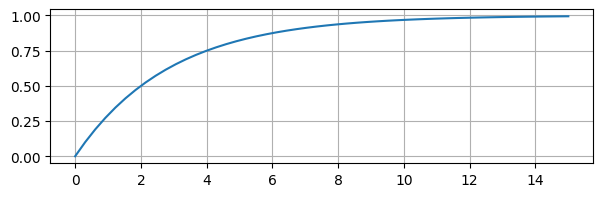

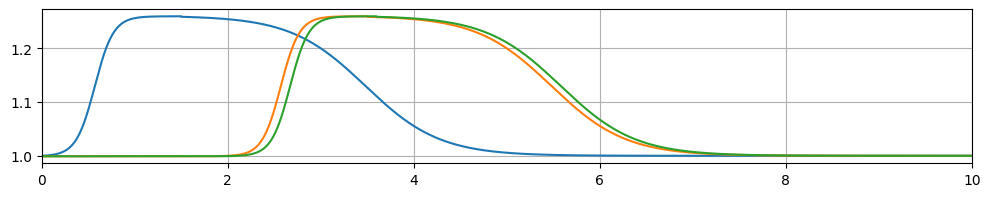

In [3]:
# preparation

il.reload(oc)
il.reload(pbs.td)


pfl = bs.dtPropofolBolus(input1=0, input2=0)

dd = np.linspace(0, 15)

plt.figure(figsize=(7, 2))
plt.grid()
plt.plot(dd, pfl.propofol_bolus_static_values_np(dd))


tt = np.linspace(0, 20, 5000)

plt.figure(figsize=(12, 2))


plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2))
plt.plot(tt, pfl.propofol_bolus_sensitivity_dynamics_np(tt-2.1))
plt.xticks(range(0, 20, 2))
plt.xlim(0, 10)
plt.grid()    
    
    

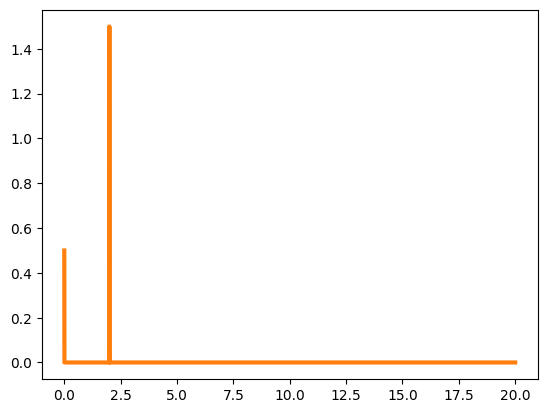

In [4]:
# table from slide 30
# input signal of boli
u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

plt.plot(tt, u_func(tt), "-", color="tab:orange", lw=3)


In [5]:

il.reload(oc)
il.reload(pbs.td)
dt = 1

bp_normal = 100

u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0 + dt)), (1.5, apx(t, 2 + dt)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

l1 = pbs.td.get_loop_symbol()
bp_sum  = pbs.td.StaticBlock(output_expr=100 + l1)
bp_delay_block = pbs.td.dtDelay1(input1=bp_sum.Y)


# dtPropofolBolus - output: Propfol-related BP difference
pfl = bs.dtPropofolBolus(input1=u_expr_propofol_boli, input2=bp_delay_block.Y)
pbs.td.set_loop_symbol(l1, pfl.Y)


T_end = 12
N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}


kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv, rhs_options={"use_sp2c": False})

In [6]:
counter_symbols = pfl.counter_states[::3]

all_idcs = np.arange(len(pbs.td.ds.all_state_vars))

def get_idcs(symbs):
    if isinstance(symbs, sp.Symbol):
        symbs = (symbs,)
    assert isinstance(symbs, (list, tuple))
    
    idcs = np.array([i for (i, s) in enumerate(pbs.td.ds.all_state_vars) if sp.sympify(s) in symbs])
    return idcs

counter_idcs = get_idcs(counter_symbols) ##:
bp_amplitude_idcs = counter_idcs + 2 ##:

    


counter_idcs := array([ 6,  9, 12])

---

bp_amplitude_idcs := array([ 8, 11, 14])

---

In [7]:
def plot_results():
    

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(15, 10));

    ax1.plot(kk*T, xx[:, counter_idcs], label="counters")
    ax1.legend()
    ax2.plot(kk*T, pfl.propofol_bolus_sensitivity_dynamics_np(6-xx[:, counter_idcs].T*T), label="isolated sensitivity")
    ax2.legend()
    ax3.plot(kk*T, xx[:, get_idcs(pfl.x2)], label="combined sensitivity for bis")
    ax3.legend()
    ax3.set_ylim(.98, 1.31)

    # amplitude debugging
    ax4.plot(kk, xx[:, bp_amplitude_idcs], ".-", ms=1, label="bp effect amplitude")
    #ax4.plot(kk, xx[:, 3], "-k")
    #ax4.plot(kk, u_func(kk*T), "-", color="magenta", lw=0.5)
    ax4.legend()
    
    # plot bp effects of single dose
    ax = ax5
    single_dose_effect_dynamics_func = st.expr_to_func(pbs.td.t, pfl.bp_effect_dynamics_expr)
    for idx_c, idx_bpa in zip(counter_idcs, bp_amplitude_idcs):
        counter_time = xx[:, idx_c]*T
        ee = single_dose_effect_dynamics_func(counter_time)*xx[:, idx_bpa]
        ax.hlines([-8, -18.6], 0, 120, color="0.5", alpha=0.3)
        ax.plot(kk, ee, ".-", ms=1, label="bp effects single dose")
        ax.legend()

    ax6.plot(kk*T, bo[bp_delay_block], label="bp effect")
    ax6.legend()


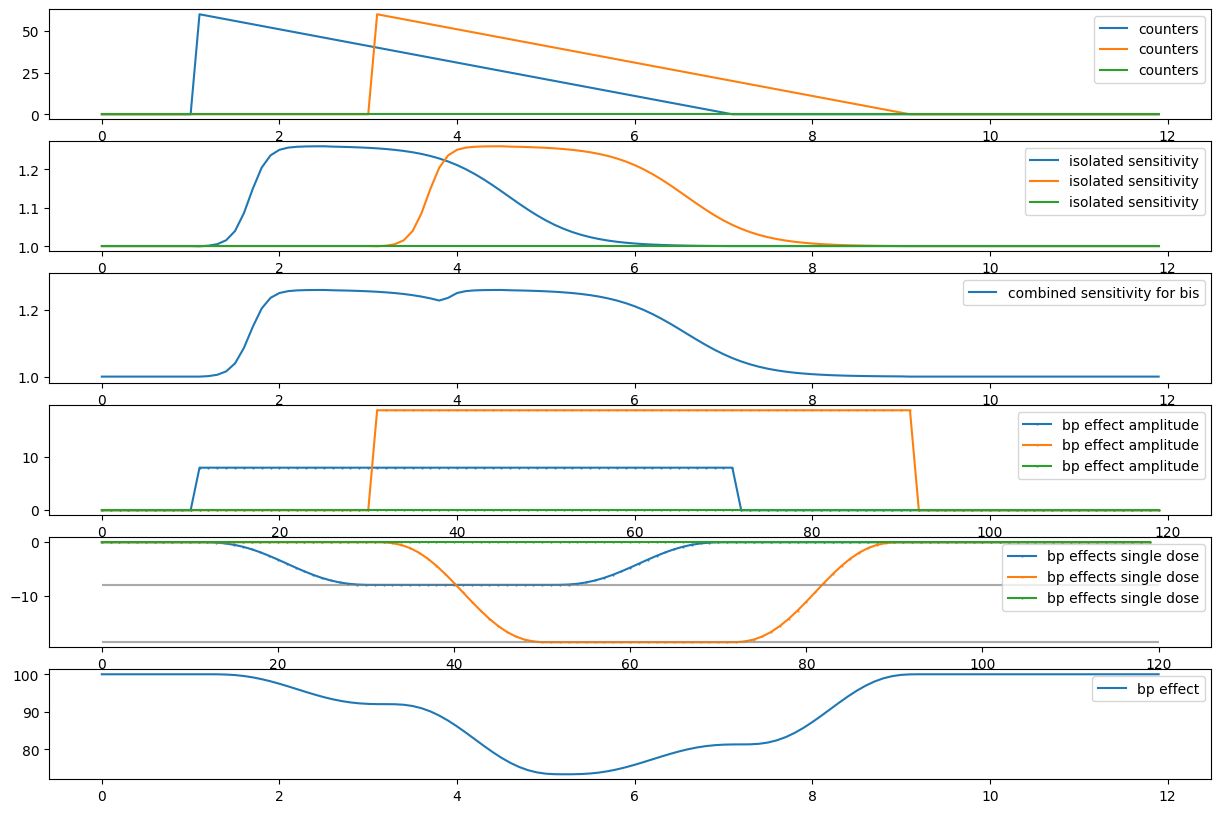

In [8]:
plot_results()

In [ ]:
dt = 3
T_end = 40

u_expr_propofol_boli = sp.Piecewise((0.5, apx(t, 0)), (1.5, apx(t, 2)), (1.5, apx(t, 12)), (1.5, apx(t, 18)), (1.5, apx(t, 25)), (0, True))
u_func = st.expr_to_func(t, u_expr_propofol_boli)

pfl.set_inputs(input1=u_expr_propofol_boli, input2=bp_delay_block.Y)
pbs.td.generate_input_func()

N_steps = int(T_end/T)

bp_start = bp_normal
iv = {bp_delay_block.x1:bp_start, pfl.x1: 0, pfl.x2: 1}

kk, xx, bo = pbs.td.blocksimulation(N_steps, iv=iv)

In [ ]:
plot_results()